# Fama and French Factor Model #

### Import Data ###

In [3]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm

# Manipulate Files
import os

# Pretty Notation
from IPython.display import display, Math

In [4]:
# Get the important data for the Risk Free Rate

rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index, dayfirst=True)

# Get the important data for the S&P500

sp500 = pd.read_csv(r"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index)

# Get the data for the Stocks' Betas

betas_df = pd.read_csv(r"..\additional_data\betas.csv")
betas_df = betas_df.set_index('Date')
betas_df.index = pd.to_datetime(betas_df.index)

In [5]:
# Create the Weights function
def wexp(N, half_life):
    c = np.log(0.5)/half_life
    n = np.array(range(N))
    w = np.exp(c*n)
    return np.flip(w/np.sum(w))

# Create the CAPM 
def CAPM(
    stock_prices: pd.Series, 
    benchmark_prices: pd.Series = sp500['sp_500'], 
    risk_free_rate: pd.Series = rfr['risk_free_rate'], 
    window: int = 252,
    WLS: bool = True,
):

    # Align time series to the same date range
    common_index = stock_prices.index.intersection(benchmark_prices.index).intersection(risk_free_rate.index)
    stock_prices = stock_prices.loc[common_index]
    benchmark_prices = benchmark_prices.loc[common_index]
    risk_free_rate = risk_free_rate.loc[common_index]
    
    # Compute daily returns
    stock_returns = stock_prices.pct_change(1)
    benchmark_returns = benchmark_prices.pct_change(1)
    risk_free_daily = (((1 + (risk_free_rate.div(100)))**(1/360)) - 1)  # Convert annual rate to daily
    
    # Excess returns
    excess_stock = stock_returns - risk_free_daily
    excess_benchmark = benchmark_returns - risk_free_daily

    alphas, betas = [], []

    # Create weights with exponential decay
    weights = window * wexp(window, window/2)
    
    for t in range(window, len(stock_returns)):
        X = excess_benchmark.iloc[t-window:t]
        y = excess_stock.iloc[t-window:t]
        
        if X.isnull().any() or y.isnull().any():
            continue

        if WLS:
            
            # Fit WLS regression
            model = sm.WLS(y, sm.add_constant(X), weights=weights, missing='drop').fit()

        else:

            # Fit OLS regression
            model = sm.OLS(y, sm.add_constant(X), missing='drop').fit()

        # Avoid KeyError by checking if params exist
        params = model.params
        
        alphas.append(params.iloc[0])
        betas.append(params.iloc[1])
            
    parameters = pd.DataFrame({
        'alpha': alphas,
        'beta': betas,
    }, index=stock_returns.index[window+1:])
    
    return parameters

In [6]:
# Folder Path
folder_path = r"..\stocks"

# Dictionary to store the DataFrames
dataframes = {}

# List all files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        # Full path to the file
        file_path = os.path.join(folder_path, file)
        
        # Read the Excel file
        df = pd.read_csv(file_path)
        df = df.set_index("Date")
        df.index = pd.to_datetime(df.index)

        df = df[['Adjusted_close', 'Market_cap_calculado', 'Price_to_Book_inverse']]

        df = df.rename(columns={
            'Adjusted_close':'adj_close',
            'Market_cap_calculado':'market_cap',
            'Price_to_Book_inverse':'book_to_price',
        })

        # Fill nans
        df['adj_close'] = df['adj_close'].interpolate(method='linear')
        df['market_cap'] = df['market_cap'].interpolate(method='linear')
        df['book_to_price'] = df['book_to_price'].interpolate(method='linear')

        df = df.loc['2015-01-01':]

        df.dropna(inplace=True)
        
        if len(df) >= 2000:
            # File name without extension
            file_name = os.path.splitext(file)[0]
            
            # Guardar en el diccionario
            dataframes[file_name] = df
            print(f"File loaded: {file_name} ({len(df)} rows)")
        else:
            print(f"File skipped (less than 2000 rows after cleaning): {file}")

print(f"\nTotal files loaded: {len(dataframes)}")
print("Files loaded:", list(dataframes.keys()))

File loaded: A (2472 rows)
File loaded: AAPL (2472 rows)
File loaded: ABBV (2472 rows)
File skipped (less than 2000 rows after cleaning): ABNB.csv
File loaded: ABT (2472 rows)
File loaded: ADBE (2472 rows)
File loaded: ADI (2472 rows)
File loaded: ADM (2472 rows)
File loaded: ADP (2472 rows)
File loaded: ADSK (2472 rows)
File loaded: AEE (2472 rows)
File loaded: AEP (2472 rows)
File loaded: AES (2472 rows)
File loaded: AFL (2472 rows)
File loaded: AIG (2472 rows)
File loaded: AIZ (2472 rows)
File loaded: AJG (2472 rows)
File loaded: AKAM (2472 rows)
File loaded: ALB (2472 rows)
File loaded: ALGN (2472 rows)
File loaded: ALL (2472 rows)
File loaded: AMAT (2472 rows)
File loaded: AMD (2472 rows)
File loaded: AME (2472 rows)
File loaded: AMGN (2472 rows)
File loaded: AMP (2472 rows)
File loaded: AMT (2472 rows)
File loaded: AMZN (2472 rows)
File loaded: ANET (2472 rows)
File loaded: ANSS (2472 rows)
File loaded: AOS (2472 rows)
File loaded: APA (2472 rows)
File loaded: APD (2472 rows)
Fil

In [7]:
# Create a whole new dataframe that contains all the stocks betas

rets_series = []

for stock, df in dataframes.items():
    series = df['adj_close'].pct_change(1).rename(stock)  
    series = series.iloc[1:]
    rets_series.append(series)

# Concat
returns_df = pd.concat(rets_series, axis=1)
returns_df = returns_df.apply(lambda x: x.fillna(x.mean()), axis=0)

# Drop nans
returns_df.dropna(inplace = True)

returns_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.018738,-0.028172,-0.018819,0.000223,-0.004976,-0.018275,-0.034602,-0.000720,-0.014614,-0.010002,...,-0.013804,0.000000,-0.017020,-0.011351,-0.027362,-0.062237,-0.020318,0.037303,-0.014077,-0.006003
2015-01-06,-0.015578,0.000094,-0.004950,-0.011356,-0.020144,-0.023384,-0.019713,-0.008350,-0.019775,-0.011641,...,-0.017107,-0.001108,-0.021331,0.005321,-0.005316,-0.005881,-0.012274,-0.008477,-0.007205,-0.009756
2015-01-07,0.013272,0.014022,0.040417,0.008108,0.008223,0.010516,0.015031,0.008784,-0.002087,0.007778,...,0.016218,0.003050,0.029368,0.008635,0.010133,0.007887,0.033138,0.024870,0.025465,0.020643
2015-01-08,0.029975,0.038422,0.010459,0.020554,0.025383,0.017655,-0.014609,0.022940,0.024747,0.003528,...,0.019657,0.010779,0.012031,0.011599,0.016645,0.007546,0.017420,0.010617,0.021359,0.015399
2015-01-09,-0.007337,0.001072,-0.027355,-0.010508,-0.014743,-0.000730,-0.008530,-0.007162,-0.009014,-0.011206,...,-0.011453,-0.001367,0.012499,-0.012285,-0.001410,-0.018863,-0.001767,-0.014424,0.014613,0.001584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,-0.024130,-0.002622,0.011901,-0.007437,-0.009242,-0.004653,-0.007839,0.001478,-0.004486,-0.005327,...,-0.002959,-0.019820,0.010471,0.003941,0.005163,-0.008678,-0.004776,-0.008935,-0.001584,0.000317
2024-10-23,-0.003222,-0.021623,-0.004662,0.007664,-0.016386,0.009928,0.007003,-0.004462,-0.007574,0.016408,...,0.000140,0.006319,-0.017304,0.010050,-0.003563,0.002664,0.004949,0.004220,-0.010511,-0.002744
2024-10-24,-0.017590,-0.000823,0.009421,-0.004017,-0.004453,0.012475,0.007489,-0.002103,-0.001834,-0.002130,...,0.154343,0.008791,0.002252,0.012282,-0.005654,-0.008123,-0.006417,-0.006686,-0.016409,-0.039632


In [8]:
# Create a whole new dataframe that contains all the stocks betas

mktcap_series = []

for stock, df in dataframes.items():
    series = df['market_cap'].rename(stock)  
    series = series.iloc[1:]
    mktcap_series.append(series)

# Concat
mktcap_df = pd.concat(mktcap_series, axis=1)
mktcap_df = mktcap_df.apply(lambda x: x.fillna(x.mean()), axis=0)

# Drop nans
mktcap_df.dropna(inplace = True)

# Apply Logs and EMA (maybe)
mktcap_df = np.log(mktcap_df)
#mktcap_df = mktcap_df.ewm(span=21, adjust = False).mean()
mktcap_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,23.310518,27.158261,25.354579,24.963717,24.303701,23.554108,24.216559,24.414648,23.314509,23.125296,...,22.020014,23.586216,23.406606,23.616339,26.669565,22.608591,23.826613,23.684291,22.100188,23.794869
2015-01-06,23.294818,27.158355,25.349617,24.952296,24.283351,23.530446,24.196649,24.406262,23.294536,23.113587,...,22.002759,23.585107,23.385044,23.621646,26.664234,22.602693,23.814263,23.675778,22.092957,23.785065
2015-01-07,23.308003,27.172280,25.389238,24.960372,24.291541,23.540908,24.211569,24.415008,23.292447,23.121335,...,22.018847,23.588152,23.413990,23.630244,26.674316,22.610549,23.846864,23.700344,22.118103,23.805498
2015-01-08,23.337537,27.209982,25.399643,24.980717,24.316607,23.558408,24.196852,24.437689,23.316893,23.124857,...,22.038314,23.598874,23.425949,23.641776,26.690823,22.618067,23.864134,23.710905,22.139237,23.820779
2015-01-09,23.330173,27.211054,25.371907,24.970154,24.301754,23.557678,24.188286,24.430501,23.307838,23.113587,...,22.026795,23.597506,23.438370,23.629415,26.689413,22.599024,23.862366,23.696376,22.153745,23.822363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,24.416692,28.909263,26.532427,26.031113,26.123266,25.437491,24.075587,25.501514,24.850774,23.876616,...,23.757865,23.859889,23.127566,24.292551,27.007904,24.186178,24.346917,23.784920,23.677344,25.177636
2024-10-23,24.416692,28.887403,26.527754,26.031113,26.106744,25.447370,24.082566,25.497042,24.843171,23.892891,...,23.758005,23.866188,23.110111,24.302551,27.004335,24.188839,24.351854,23.789132,23.666778,25.174888
2024-10-24,24.416692,28.886579,26.537131,26.031113,26.102281,25.459768,24.090027,25.494936,24.841336,23.890759,...,23.900158,23.873894,23.112361,24.314759,26.998665,24.180682,24.345417,23.782424,23.650233,25.134450


In [9]:
# Create a whole new dataframe that contains all the stocks betas

btp_series = []

for stock, df in dataframes.items():
    series = df['book_to_price'].rename(stock)  
    series = series.iloc[1:]
    btp_series.append(series)

# Concat
btp_df = pd.concat(btp_series, axis=1)
btp_df = btp_df.apply(lambda x: x.fillna(x.mean()), axis=0)

btp_df.dropna(inplace = True)
#btp_df = btp_df.ewm(span=21, adjust = False).mean()

btp_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,0.409533,0.178968,0.034847,0.341252,0.187557,0.279461,0.608711,0.154433,0.169972,0.613277,...,0.265244,0.333579,0.006472,0.562626,0.472326,0.327541,0.112471,0.317620,0.201647,0.063217
2015-01-06,0.416013,0.178951,0.035020,0.345171,0.191413,0.286152,0.620952,0.155734,0.173401,0.620500,...,0.269861,0.333949,0.006613,0.559648,0.474850,0.329478,0.113869,0.320335,0.203110,0.063840
2015-01-07,0.410564,0.176476,0.033660,0.342395,0.189852,0.283174,0.611756,0.154377,0.173763,0.615711,...,0.265554,0.332933,0.006425,0.554857,0.470087,0.326900,0.110216,0.312561,0.198066,0.062549
2015-01-08,0.398616,0.169947,0.033312,0.335499,0.185152,0.278261,0.620826,0.150915,0.169567,0.613547,...,0.260434,0.329383,0.006348,0.548495,0.462391,0.324452,0.108329,0.309278,0.193924,0.061600
2015-01-09,0.401562,0.169765,0.034248,0.339062,0.187922,0.278465,0.626167,0.152004,0.171109,0.620500,...,0.263452,0.329834,0.006270,0.555317,0.463043,0.330689,0.108521,0.313804,0.191131,0.061503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,0.146906,0.018580,0.020334,0.194725,0.067040,0.315543,0.844693,0.038249,0.039888,0.492817,...,0.123928,0.436246,-0.009920,0.505872,0.500503,0.324070,-0.203607,0.596409,0.171340,0.057743
2024-10-23,0.146906,0.018991,0.020429,0.194725,0.068156,0.312441,0.838818,0.038420,0.040193,0.484861,...,0.123911,0.433507,-0.010095,0.500838,0.502293,0.323209,-0.202604,0.593902,0.173160,0.057902
2024-10-24,0.146906,0.019006,0.020238,0.194725,0.068461,0.308591,0.832583,0.038501,0.040267,0.485896,...,0.114804,0.425126,-0.010072,0.494761,0.505149,0.325856,-0.203913,0.597900,0.176049,0.060291


### Create the Fama & French Portfolios ###

In [11]:
# Define the Decomposition Function
def fama_and_french_decomposition(
    target_df, 
    mktcap_df, 
    value_df
):
    # Common Indexes
    common_index = target_df.index.intersection(value_df.index).intersection(mktcap_df.index)
    
    # Reindex
    target_df = target_df.loc[common_index]
    mktcap_df = mktcap_df.loc[common_index]
    value_df = value_df.loc[common_index]

    # Initialize lists to store portfolio returns
    small_low_list, small_neutral_list, small_high_list = [], [], []
    big_low_list, big_neutral_list, big_high_list = [], [], []
    
    # Get unique quarters
    quarters = sorted(set([date.to_period('Q') for date in common_index]))
    
    # Dictionary to store quarterly classifications and weights
    quarterly_classifications = {}

    for quarter in quarters:
        # Select only the last available date of the quarter
        quarter_dates = [date for date in common_index if date.to_period('Q') == quarter]
        rebalance_date = quarter_dates[-1]  # Last day of the quarter
        
        # Size factor for rebalance date
        size_factor_df = pd.DataFrame([mktcap_df.loc[rebalance_date]], index=['mkt_cap']).T.dropna()
        
        # Value factor (P/B ratio) for rebalance date
        value_factor_df = pd.DataFrame([value_df.loc[rebalance_date]], index=['btp']).T.dropna()

        # Threshold for size
        median = size_factor_df['mkt_cap'].median()

        # Classify stocks into Low, Neutral, and High based on quantiles
        lower = value_factor_df['btp'].quantile(0.3)
        upper = value_factor_df['btp'].quantile(0.7)

        # Merge the two
        combined_df = size_factor_df.join(value_factor_df, how='inner')

        # Classify for Size
        combined_df['size_class'] = 'small'
        combined_df.loc[combined_df['mkt_cap'] > median, 'size_class'] = 'big'

        # Classify for Value
        combined_df['value_class'] = 'neutral'
        combined_df.loc[combined_df['btp'] <= lower, 'value_class'] = 'high'
        combined_df.loc[combined_df['btp'] >= upper, 'value_class'] = 'low'
        
        # Create the FF Portfolios
        combined_df['ff_class'] = combined_df['size_class'] + '_' + combined_df['value_class']
        
        # Market cap data
        market_caps_df = pd.DataFrame([mktcap_df.loc[rebalance_date]], index=['mkt_cap']).T
        
        # Assign market caps to value classes
        small_low_mktcap_df = market_caps_df.loc[combined_df[combined_df['ff_class'] == 'small_low'].index]
        small_neutral_mktcap_df = market_caps_df.loc[combined_df[combined_df['ff_class'] == 'small_neutral'].index]
        small_high_mktcap_df = market_caps_df.loc[combined_df[combined_df['ff_class'] == 'small_high'].index]
        big_low_mktcap_df = market_caps_df.loc[combined_df[combined_df['ff_class'] == 'big_low'].index]
        big_neutral_mktcap_df = market_caps_df.loc[combined_df[combined_df['ff_class'] == 'big_neutral'].index]
        big_high_mktcap_df = market_caps_df.loc[combined_df[combined_df['ff_class'] == 'big_high'].index]
        
        # Compute weights
        small_low_weights = small_low_mktcap_df['mkt_cap'] / small_low_mktcap_df['mkt_cap'].sum()
        small_neutral_weights = small_neutral_mktcap_df['mkt_cap'] / small_neutral_mktcap_df['mkt_cap'].sum()
        small_high_weights = small_high_mktcap_df['mkt_cap'] / small_high_mktcap_df['mkt_cap'].sum()
        big_low_weights = big_low_mktcap_df['mkt_cap'] / big_low_mktcap_df['mkt_cap'].sum()
        big_neutral_weights = big_neutral_mktcap_df['mkt_cap'] / big_neutral_mktcap_df['mkt_cap'].sum()
        big_high_weights = big_high_mktcap_df['mkt_cap'] / big_high_mktcap_df['mkt_cap'].sum()
        
        # Store classifications and weights
        quarterly_classifications[quarter] = {
            "small_low": small_low_weights,
            "small_neutral": small_neutral_weights,
            "small_high": small_high_weights,
            "big_low": big_low_weights, 
            "big_neutral": big_neutral_weights,
            "big_high": big_high_weights,
        }
    
    # Iterate over all available dates to compute daily returns
    for date in common_index:
        quarter_key = date.to_period('Q')  # Get quarter of the current date
        
        if quarter_key in quarterly_classifications:
            # Retrieve stored classification and weights
            small_low_weights = quarterly_classifications[quarter_key]["small_low"]
            small_neutral_weights = quarterly_classifications[quarter_key]["small_neutral"]
            small_high_weights = quarterly_classifications[quarter_key]["small_high"]
            big_low_weights = quarterly_classifications[quarter_key]["big_low"]
            big_neutral_weights = quarterly_classifications[quarter_key]["big_neutral"]
            big_high_weights = quarterly_classifications[quarter_key]["big_high"]
            
            # Retrieve daily returns
            target = pd.DataFrame([target_df.loc[date]], index=['returns']).T
            
            small_low_returns = target.reindex(small_low_weights.index).dropna()
            small_neutral_returns = target.reindex(small_neutral_weights.index).dropna()
            small_high_returns = target.reindex(small_high_weights.index).dropna()
            big_low_returns = target.reindex(big_low_weights.index).dropna()
            big_neutral_returns = target.reindex(big_neutral_weights.index).dropna()
            big_high_returns = target.reindex(big_high_weights.index).dropna()
            
            # Compute portfolio returns
            small_low_result = small_low_weights.reindex(small_low_returns.index).T @ small_low_returns
            small_neutral_result = small_neutral_weights.reindex(small_neutral_returns.index).T @ small_neutral_returns
            small_high_result = small_high_weights.reindex(small_high_returns.index).T @ small_high_returns
            big_low_result = big_low_weights.reindex(big_low_returns.index).T @ big_low_returns
            big_neutral_result = big_neutral_weights.reindex(big_neutral_returns.index).T @ big_neutral_returns
            big_high_result = big_high_weights.reindex(big_high_returns.index).T @ big_high_returns
            
            # Store results
            small_low_list.append(small_low_result.values[0] if not small_low_result.empty else None)
            small_neutral_list.append(small_neutral_result.values[0] if not small_neutral_result.empty else None)
            small_high_list.append(small_high_result.values[0] if not small_high_result.empty else None)
            big_low_list.append(big_low_result.values[0] if not big_low_result.empty else None)
            big_neutral_list.append(big_neutral_result.values[0] if not big_neutral_result.empty else None)
            big_high_list.append(big_high_result.values[0] if not big_high_result.empty else None)

    # Create final DataFrame
    ff_portfolios = pd.DataFrame({
        'small_high': small_high_list,
        'small_neutral': small_neutral_list,
        'small_low': small_low_list,
        'big_high': big_high_list,
        'big_neutral': big_neutral_list,
        'big_low': big_low_list
    }, index=common_index)
    
    return ff_portfolios

In [12]:
# Create DataFrames

ff_portfolio_returns = fama_and_french_decomposition(returns_df, mktcap_df, btp_df)

ff_portfolio_returns

,small_high,small_neutral,small_low,big_high,big_neutral,big_low
Date,,,,,,
2015-01-05,-0.010459,-0.017731,-0.019193,-0.014599,-0.013963,-0.020759
2015-01-06,-0.012227,-0.009333,-0.011213,-0.006283,-0.009100,-0.008987
2015-01-07,0.014323,0.011499,0.013542,0.016110,0.012527,0.009075
2015-01-08,0.020081,0.018929,0.018763,0.017946,0.019163,0.013737
2015-01-09,-0.005535,-0.006319,-0.007662,-0.008600,-0.007683,-0.008941
...,...,...,...,...,...,...
2024-10-22,-0.005939,-0.009346,-0.005226,-0.004979,-0.001656,0.002557
2024-10-23,-0.004336,-0.002237,-0.001237,-0.007618,-0.002842,0.000081
2024-10-24,0.004065,0.002508,-0.000885,0.002700,-0.002118,-0.005485


In [13]:
# Check the Annualized Mean Returns

ff_portfolio_returns.mean().mul(100).mul(252)

small_high       23.866110
small_neutral    14.218830
small_low         4.506770
big_high         22.349086
big_neutral      14.775437
big_low           7.977273
dtype: float64

In [14]:
# Check the Annualized Volatility

ff_portfolio_returns.std().mul(100).mul(np.sqrt(252))

small_high       19.158208
small_neutral    18.982782
small_low        22.684275
big_high         18.013312
big_neutral      16.384650
big_low          19.658494
dtype: float64

In [15]:
# Check the Risk Adjusted Returns

ff_portfolio_returns.mean().mul(100).mul(252) / ff_portfolio_returns.std().mul(100).mul(np.sqrt(252))

small_high       1.245738
small_neutral    0.749038
small_low        0.198674
big_high         1.240698
big_neutral      0.901785
big_low          0.405793
dtype: float64

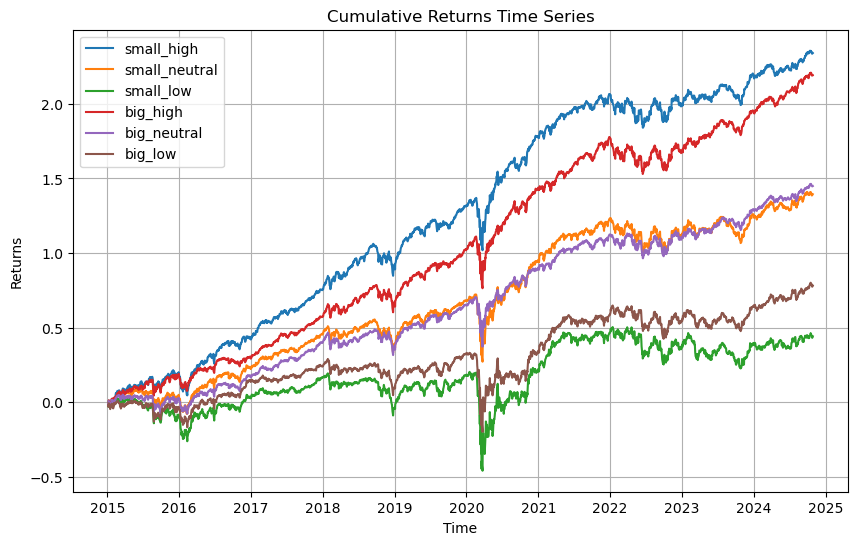

In [16]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(ff_portfolio_returns.cumsum(), label=ff_portfolio_returns.columns, alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [17]:
# Create DataFrames

ff_portfolio_betas = fama_and_french_decomposition(betas_df, mktcap_df, btp_df)

ff_portfolio_betas

,small_high,small_neutral,small_low,big_high,big_neutral,big_low
Date,,,,,,
2016-01-08,0.959933,0.960345,1.064385,0.939677,0.949075,0.984126
2016-01-11,0.961131,0.959904,1.050217,0.954260,0.950094,0.983068
2016-01-12,0.960375,0.959270,1.049014,0.953649,0.949319,0.983430
2016-01-13,0.958840,0.958742,1.042001,0.953820,0.950183,0.982310
2016-01-14,0.962710,0.959790,1.044513,0.962294,0.949933,0.978760
...,...,...,...,...,...,...
2024-10-22,0.698270,0.804707,0.692829,0.870135,0.715530,0.574856
2024-10-23,0.699013,0.804609,0.691160,0.870351,0.714800,0.573170
2024-10-24,0.696714,0.798176,0.681880,0.870200,0.710302,0.564795


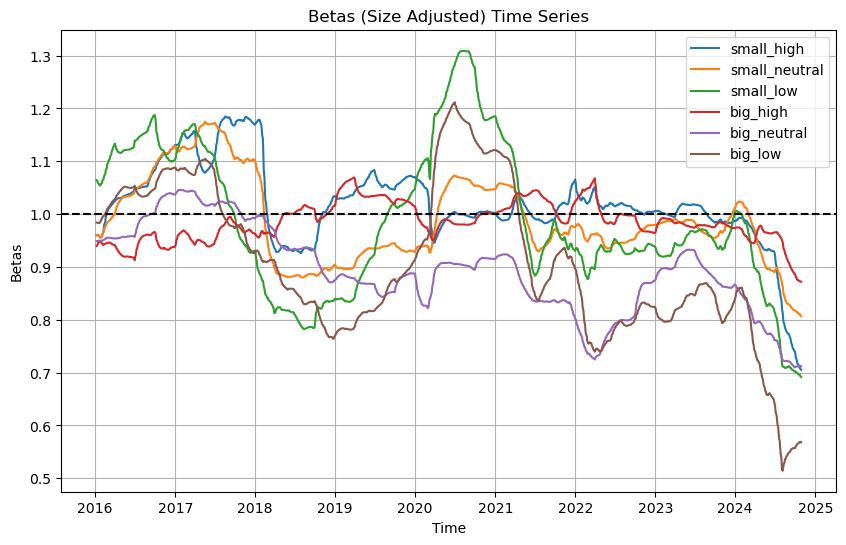

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(ff_portfolio_betas.ewm(span=21, adjust = False).mean(), label=ff_portfolio_betas.columns, alpha=1)
plt.axhline(y=1, color='black', linestyle='dashed')

# Config
plt.title('Betas (Size Adjusted) Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()
plt.grid()

# Show
plt.show()

In [19]:
# Calculate the SMB Premium

SMB = (1/3)*(ff_portfolio_returns['small_low'] + ff_portfolio_returns['small_neutral'] + ff_portfolio_returns['small_high']) \
    - (1/3)*(ff_portfolio_returns['big_low'] + ff_portfolio_returns['big_neutral'] + ff_portfolio_returns['big_high'])

SMB

Date
2015-01-05    0.000646
2015-01-06   -0.002801
2015-01-07    0.000551
2015-01-08    0.002309
2015-01-09    0.001903
                ...   
2024-10-22   -0.005477
2024-10-23    0.000856
2024-10-24    0.003531
2024-10-25   -0.000057
2024-10-28    0.002851
Length: 2471, dtype: float64

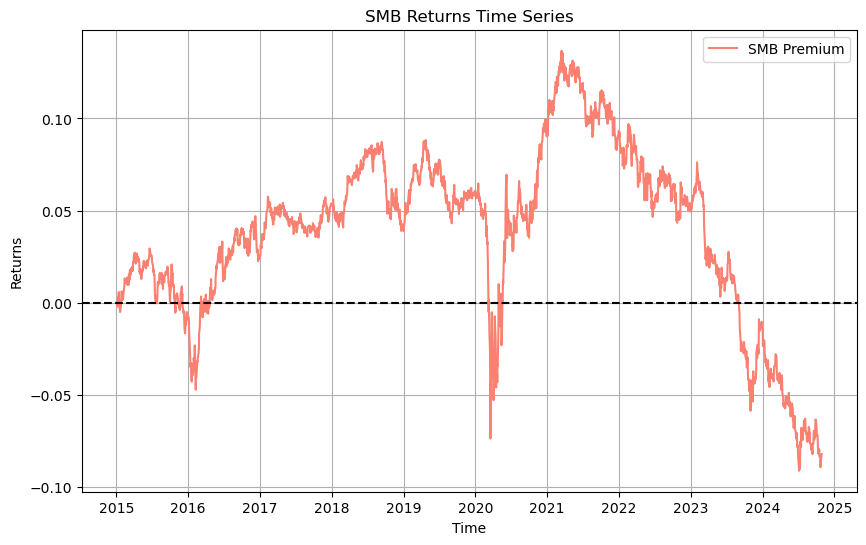

In [20]:
# Plot SMB

plt.figure(figsize=(10, 6))
plt.plot(SMB.cumsum(), label='SMB Premium', color = 'salmon', alpha=1)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('SMB Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [21]:
# Calculate the HML Premium

HML = (1/2)*(ff_portfolio_returns['small_high'] + ff_portfolio_returns['big_high']) \
    - (1/2)*(ff_portfolio_returns['small_low'] + ff_portfolio_returns['big_low'])

HML

Date
2015-01-05    0.007447
2015-01-06    0.000845
2015-01-07    0.003908
2015-01-08    0.002763
2015-01-09    0.001234
                ...   
2024-10-22   -0.004124
2024-10-23   -0.005399
2024-10-24    0.006567
2024-10-25    0.005088
2024-10-28   -0.006572
Length: 2471, dtype: float64

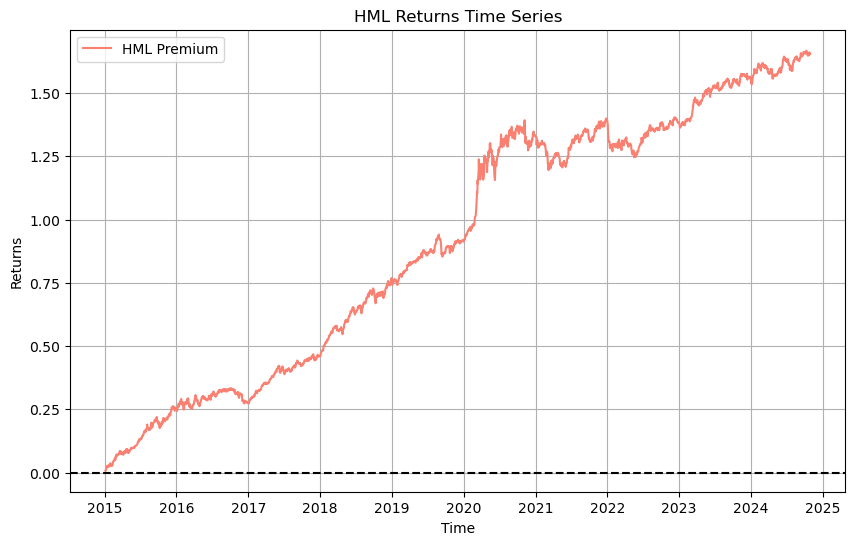

In [22]:
# Plot HML

plt.figure(figsize=(10, 6))
plt.plot(HML.cumsum(), label='HML Premium', color = 'salmon', alpha=1)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('HML Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [23]:
# Create the market data
daily_rfr = (((1 + (rfr['risk_free_rate'].div(100)))**(1/360)) - 1)
benchmark_returns = sp500['sp_500'].pct_change(1)

# Create the Excess Returns
market_excess_returns = benchmark_returns - daily_rfr

In [24]:
# Check the Correlation

print(f'SMB premium correlation  with HML premium: {SMB.corr(HML)}')
print(f'SMB premium correlation  with market premium: {SMB.corr(market_excess_returns)}')
print(f'HML premium correlation  with market premium: {HML.corr(market_excess_returns)}')

SMB premium correlation  with HML premium: -0.3381637441793601
SMB premium correlation  with market premium: 0.25341398408383725
HML premium correlation  with market premium: -0.05177835467084142


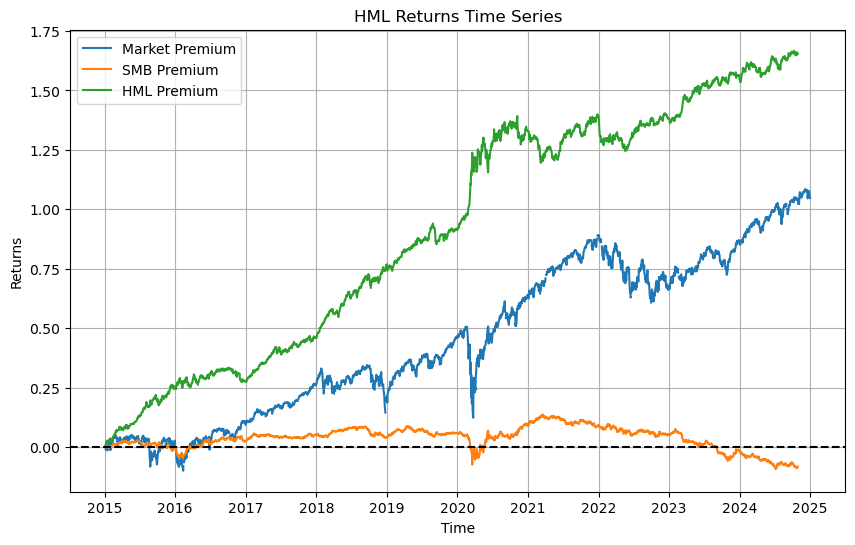

In [25]:
# Plot HML

plt.figure(figsize=(10, 6))
plt.plot(market_excess_returns.cumsum(), label='Market Premium', alpha=1)
plt.plot(SMB.cumsum(), label='SMB Premium', alpha=1)
plt.plot(HML.cumsum(), label='HML Premium', alpha=1)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('HML Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [26]:
# Store both series

SMB.to_csv(r"..\additional_data\SMB.csv")
HML.to_csv(r"..\additional_data\HML.csv")